# Basic Setup & Importing Datasets

In [206]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn
import nltk
from collections import Counter
from langdetect import detect, LangDetectException

In [207]:
#reading data
trainingset = pd.read_csv("mediaeval-2015-trainingset.txt", sep="\t")
testingset = pd.read_csv("mediaeval-2015-testset.txt", sep="\t")

#convert to dataframe
df_train = pd.DataFrame(data=trainingset)
df_test = pd.DataFrame(data=testingset)

# Exploring The Datasets

In [208]:
#summary of datasets and their size
trainingset.info() 
print("\n")
testingset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14277 entries, 0 to 14276
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   tweetId     14277 non-null  int64 
 1   tweetText   14277 non-null  object
 2   userId      14277 non-null  int64 
 3   imageId(s)  14277 non-null  object
 4   username    14277 non-null  object
 5   timestamp   14277 non-null  object
 6   label       14277 non-null  object
dtypes: int64(2), object(5)
memory usage: 780.9+ KB


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3755 entries, 0 to 3754
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   tweetId     3755 non-null   int64 
 1   tweetText   3755 non-null   object
 2   userId      3755 non-null   int64 
 3   imageId(s)  3755 non-null   object
 4   username    3755 non-null   object
 5   timestamp   3755 non-null   object
 6   label       3755 non-null   object
dtypes: int6

In [209]:
#determining the ratio of training data : test data
totalentries = 14277 + 3755
print("Total entries: ", totalentries) 
print("Data split: ", round(((14277/totalentries)*100),2), "% to", round(((3755/totalentries)*100),2), "%")

Total entries:  18032
Data split:  79.18 % to 20.82 %


In [210]:
#replacing all humor labels as fake
df_train.replace("humor", "fake", inplace=True)
df_test.replace("humor", "fake", inplace=True)

In [211]:
#determine the ratio of real : fake labels in training data
training_real =  df_train[df_train["label"].str.contains("real")].shape[0]
training_fake =  df_train[df_train["label"].str.contains("fake")].shape[0]

print("In Training Data:")
print("Real entries: ",training_real, "/ Fake entries: ",training_fake)
print("Label split:",round(((training_real/14277)*100),2), "% to", round(((training_fake/14277)*100),2), "%") 

In Training Data:
Real entries:  4921 / Fake entries:  9356
Label split: 34.47 % to 65.53 %


In [212]:
#determine the ratio of real : fake labels in training data
testing_real =  df_test[df_test["label"].str.contains("real")].shape[0]
testing_fake =  df_test[df_test["label"].str.contains("fake")].shape[0]

print("In Test Data:")
print("Real entries: ",testing_real, "/ Fake entries: ",testing_fake)
print("Label split:",round(((testing_real/3755)*100),2), "% to", round(((testing_fake/3755)*100),2), "%") 

In Test Data:
Real entries:  1209 / Fake entries:  2546
Label split: 32.2 % to 67.8 %


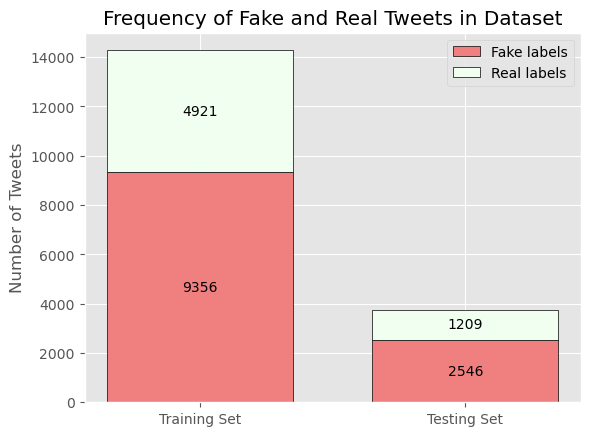

In [213]:
#plot fake and real tweets as bar chart
label_counts = {
    "Fake": np.array([training_fake, testing_fake]),
    "Real": np.array([training_real, testing_real]),
}

x = ["Training Set", "Testing Set"]

plt.style.use("ggplot")
fig, ax = plt.subplots()
bottom = np.zeros(2)

#count number of labels and iterate
for labels, label_counts in label_counts.items():
    if labels == "Fake":
        color = "lightcoral"
    else:
        color = "honeydew"
    p = ax.bar(x, label_counts, width=0.7, bottom=bottom, color=color, edgecolor="black")
    bottom += label_counts
    
    ax.bar_label(p, label_type="center")

ax.legend(["Fake labels", "Real labels"])
plt.title("Frequency of Fake and Real Tweets in Dataset")
plt.ylabel("Number of Tweets")
plt.show()

#
#Ref; Stacked Bar Chart Code Block by User: OriolAbril, answered 2018 (Online: https://stackoverflow.com/a/50161387)

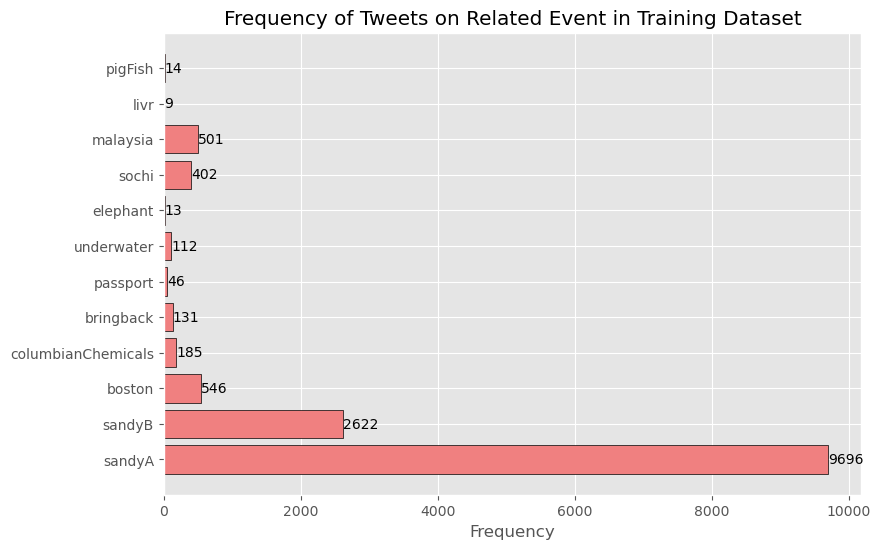

In [214]:
#in training data, rename imageId(s) to image 
df_train.rename(columns={"imageId(s)": "image"}, inplace=True)

#tokenize events and index without "_fake_19" / "_true_2", etc.
event_list = df_train["image"].str.split("_").str[0]

#represent as a bar chart
plt.style.use("ggplot")
fig, ax = plt.subplots(figsize=(9,6))

#count occurances and store as variables for plotting
event, frequency = zip(*Counter(event_list).items())
bars = ax.barh(event, frequency, color="lightcoral", edgecolor="black")

for bar, freq in zip(bars, frequency):
    ax.text(bar.get_width(), bar.get_y() + bar.get_height()/2, 
            f"{freq}", ha="left", va="center")

plt.title("Frequency of Tweets on Related Event in Training Dataset")
plt.xlabel("Frequency")
plt.show()

#
#Ref; Horizontal Bar Chart Code Block by User: Igonato, answered 2013. (Online: https://stackoverflow.com/a/19199002)

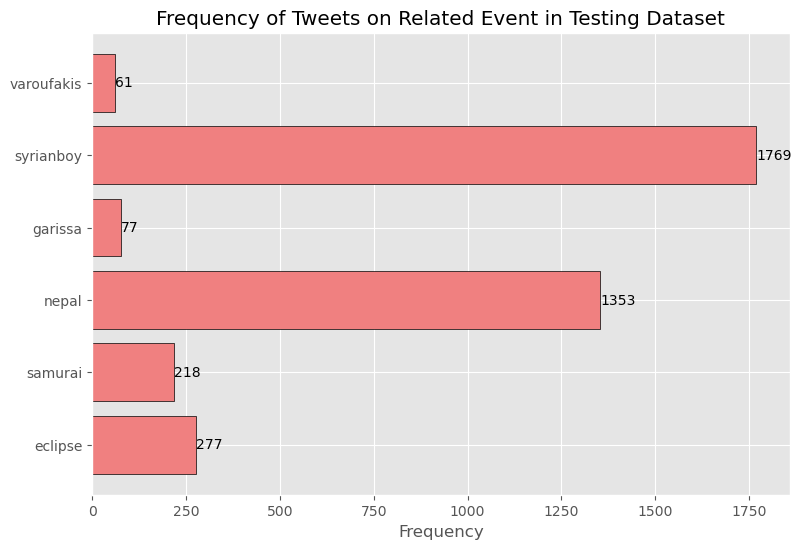

In [215]:
#in test data, rename imageId(s) to image
df_test.rename(columns={"imageId(s)": "image"}, inplace=True)

#tokenize again
event_list = df_test["image"].str.split("_").str[0]

#represent as a bar chart
plt.style.use("ggplot")
fig, ax = plt.subplots(figsize=(9,6))

#count occurances and store as variables for plotting
event, frequency = zip(*Counter(event_list).items())
bars = ax.barh(event, frequency, color='lightcoral', edgecolor='black')

for bar, freq in zip(bars, frequency):
    ax.text(bar.get_width(), bar.get_y() + bar.get_height()/2, 
            f'{freq}', ha='left', va='center')

plt.title("Frequency of Tweets on Related Event in Testing Dataset")
plt.xlabel("Frequency")
plt.show()

In [216]:
#determine no. of retweets
rt_count = df_train[df_train["tweetText"].str.contains(r"\bRT\b")].shape[0]
real_rt_count = df_train[df_train["tweetText"].str.contains(r"\bRT\b") & df_train["label"].str.contains("real")].shape[0]
fake_rt_count = df_train[df_train["tweetText"].str.contains(r"\bRT\b") & df_train["label"].str.contains("fake")].shape[0]
print("Retweets:", rt_count, "/ Real:", real_rt_count, "/ Fake:", fake_rt_count)

Retweets: 1442 / Real: 735 / Fake: 707


In [217]:
#determine no. of reposts
re_count = df_train[df_train["tweetText"].str.contains("via @\w*")].shape[0]
real_re_count = df_train[df_train["tweetText"].str.contains("via @\w*") & df_train["label"].str.contains("real")].shape[0]
fake_re_count = df_train[df_train["tweetText"].str.contains("via @\w*") & df_train["label"].str.contains("fake")].shape[0]
print("Reposts:", re_count, "/ Real:", real_re_count, "/ Fake:", fake_re_count)

Reposts: 406 / Real: 274 / Fake: 132


In [218]:
#determine no. of SandyA retweets
sandyA_rt_count = df_train[df_train["tweetText"].str.contains(r"\bRT\b") & df_train["image"].str.contains("sandyA")].shape[0]

sandyA_real_rt_count = df_train[df_train["tweetText"].str.contains(r"\bRT\b") 
                                & df_train["image"].str.contains("sandyA") \
                                & df_train["label"].str.contains("real")].shape[0]                    

sandyA_fake_rt_count = df_train[df_train["tweetText"].str.contains(r"\bRT\b") 
                                & df_train["image"].str.contains("sandyA") \
                                & df_train["label"].str.contains("fake")].shape[0] 
print("Sandy Retweets:", sandyA_rt_count, "/ Real:", sandyA_real_rt_count, "/ Fake:", sandyA_fake_rt_count)

Sandy Retweets: 760 / Real: 163 / Fake: 597


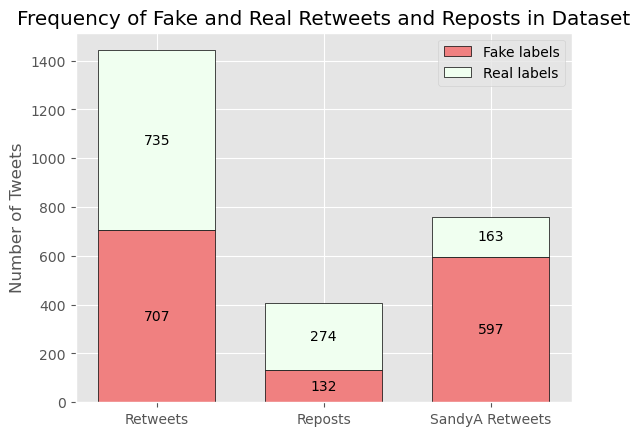

In [219]:
#plot RTs and reposts as bar chart
label_counts = {
    "Fake": np.array([fake_rt_count, fake_re_count, sandyA_fake_rt_count]),
    "Real": np.array([real_rt_count, real_re_count, sandyA_real_rt_count]),
}

x = ["Retweets", "Reposts", "SandyA Retweets"]

plt.style.use("ggplot")
fig, ax = plt.subplots()
bottom = np.zeros(3)

#count number of labels and iterate
for labels, label_counts in label_counts.items():
    if labels == "Fake":
        color = "lightcoral"
    else:
        color = "honeydew"
    
    p = ax.bar(x, label_counts, width=0.7, bottom=bottom, color=color, edgecolor="black")
    bottom += label_counts
    
    ax.bar_label(p, label_type="center")

ax.legend(["Fake labels", "Real labels"])
plt.title("Frequency of Fake and Real Retweets and Reposts in Dataset")
plt.ylabel("Number of Tweets")
plt.show()

In [220]:
#detect languages in training set
def languagedetector(x):
    try:
        result = detect(x)
    except LangDetectException as e:
        result = str(e)
    return result


df_train["lang"] = df_train["tweetText"].apply(languagedetector)

#
#Ref; Code Block by User: Scott Boston, answered 2022. (Online: https://stackoverflow.com/a/72941590)

In [221]:
#top 10 common languages in training set
df_train["lang"].value_counts()[:10]

en    10963
es     1296
tl      311
fr      215
id      180
pt      163
de      122
so      121
cy      115
it      103
Name: lang, dtype: int64

In [222]:
#detect languages in testing set
def languagedetector(x):
    try:
        result = detect(x)
    except LangDetectException as e:
        result = str(e)
    return result


df_test["lang"] = df_test["tweetText"].apply(languagedetector)

In [223]:
#top 10 common languages in testing set
df_test["lang"].value_counts()[:10]

en    2784
so     502
ar     188
es      60
de      41
pt      39
fr      33
nl      21
it      18
tr      12
Name: lang, dtype: int64

# Preprocessing Training Data

In [224]:
#remove retweets and reposts

rts = r"(\bRT\b|via @|repost|REPOST)"
df_train = df_train[~df_train["tweetText"].str.contains(rts)]

df_train.shape

C:\Users\jm18g20\AppData\Local\Temp\ipykernel_13612\1790302928.py:4: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  df_train = df_train[~df_train["tweetText"].str.contains(rts)]


(12397, 8)

In [225]:
#remove links

#print(df_train.iloc[10][1])
links = r"(http\S+)"
df_train["tweetText"] = df_train["tweetText"].str.replace(links, "", case=False)
#print(df_train.iloc[10][1])

#
#Ref; Code Block by User: Vishnu Kunchur, answered 2018. (online: https://stackoverflow.com/a/51994437) 

C:\Users\jm18g20\AppData\Local\Temp\ipykernel_13612\3229091528.py:5: FutureWarning: The default value of regex will change from True to False in a future version.
  df_train["tweetText"] = df_train["tweetText"].str.replace(links, "", case=False)


In [226]:
#remove mentions (e.g @username...followed by text)

#print(df_train.iloc[23][1])
mentions = r"(@\S+)"
df_train["tweetText"] = df_train["tweetText"].str.replace(mentions,"", case=False)
#print(df_train.iloc[23][1])

C:\Users\jm18g20\AppData\Local\Temp\ipykernel_13612\1195926642.py:5: FutureWarning: The default value of regex will change from True to False in a future version.
  df_train["tweetText"] = df_train["tweetText"].str.replace(mentions,"", case=False)


In [227]:
#remove newlines, ampersands, punctuation and other noise

#print(df_train.iloc[14][1])
signs1 = r"(&amp;|(\\n))"
signs2 = r"([.,;:'!?\"-]|[:;][)(DPO3/])"
df_train["tweetText"] = df_train["tweetText"].str.replace(signs1, "", case=False)
df_train["tweetText"] = df_train["tweetText"].str.replace(signs2, "", case=False)
#print(df_train.iloc[14][1])

C:\Users\jm18g20\AppData\Local\Temp\ipykernel_13612\3269026716.py:6: FutureWarning: The default value of regex will change from True to False in a future version.
  df_train["tweetText"] = df_train["tweetText"].str.replace(signs1, "", case=False)
C:\Users\jm18g20\AppData\Local\Temp\ipykernel_13612\3269026716.py:7: FutureWarning: The default value of regex will change from True to False in a future version.
  df_train["tweetText"] = df_train["tweetText"].str.replace(signs2, "", case=False)


In [228]:
#lowercasing

#print(df_train.iloc[7][1])
#df_train["tweetText"] = df_train["tweetText"].str.lower()
#print(df_train.iloc[7][1])

#not used, only makes NB (bag of words) accuracy better while making others worse.

In [229]:
#remove emojis by only keeping extended ASCII

#print(df_train.iloc[23][1])
filter_char = lambda c: ord(c) < 256
df_train["tweetText"] = df_train["tweetText"].apply(lambda s: "".join(filter(filter_char, s)))
#print(df_train.iloc[23][1])

#
#Ref; Code block by User: xjcl, answered 2020 (online: https://stackoverflow.com/a/65109987)

In [230]:
#remove stopwords

#print(df_train.iloc[22][1])
stop = set(nltk.corpus.stopwords.words())
df_train["tweetText"] = df_train["tweetText"].apply(lambda x: ' '.join([w for w in x.split() if w not in (stop)]))
#print(df_train.iloc[22][1])

#
#Ref; Code Block by User: Keiku, answered 2017. (online: https://stackoverflow.com/a/43407993)

In [231]:
#remove whitespace

df_train["tweetText"] = df_train["tweetText"].str.strip()

In [232]:
#lammatize tweetText and creating new class in the dataframe

tokenizer = nltk.tokenize.TweetTokenizer()
lemmatizer = nltk.stem.WordNetLemmatizer()

df_train["lemmatizedText"] = df_train["tweetText"].apply(lambda x: ' '.join([lemmatizer.lemmatize(token) for token in tokenizer.tokenize(x)]))

#
#Ref; Code Block by User: titipata, answered 2017. (online: https://stackoverflow.com/a/47557782)

In [233]:
#checking changes
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12397 entries, 0 to 14276
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   tweetId         12397 non-null  int64 
 1   tweetText       12397 non-null  object
 2   userId          12397 non-null  int64 
 3   image           12397 non-null  object
 4   username        12397 non-null  object
 5   timestamp       12397 non-null  object
 6   label           12397 non-null  object
 7   lang            12397 non-null  object
 8   lemmatizedText  12397 non-null  object
dtypes: int64(2), object(7)
memory usage: 968.5+ KB


In [234]:
df_train.head()

,tweetId,tweetText,userId,image,username,timestamp,label,lang,lemmatizedText
0,263046056240115712,¿Se acuerdan película El día después mañana Me...,21226711,sandyA_fake_46,iAnnieM,Mon Oct 29 22:34:01 +0000 2012,fake,es,¿ Se acuerdan película El día después mañana M...
2,262979898002534400,Buena foto Huracán Sandy recuerda película Día...,132303095,sandyA_fake_09,LucasPalape,Mon Oct 29 18:11:08 +0000 2012,fake,es,Buena foto Huracán Sandy recuerda película Día...
3,262996108400271360,Scary shit #hurricane #NY,241995902,sandyA_fake_29,Haaaaarryyy,Mon Oct 29 19:15:33 +0000 2012,fake,en,Scary shit #hurricane #NY
4,263018881839411200,My fave place world #nyc #hurricane #sandy #st...,250315890,sandyA_fake_15,princess__natt,Mon Oct 29 20:46:02 +0000 2012,fake,en,My fave place world #nyc #hurricane #sandy #st...
5,263364439582060545,42nd #time #square #NYC #subway #hurricane,163674788,sandyA_fake_23,classycg,Tue Oct 30 19:39:10 +0000 2012,fake,en,42nd #time #square #NYC #subway #hurricane


# Model Training & Performance Analysis

In [235]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [236]:
#select lammatizedText and tweetText to extract features from
#select labels for training and evaluation

features_train = df_train["lemmatizedText"]
label_train = df_train["label"]
features_test = df_test["tweetText"]
label_test = df_test["label"]

In [237]:
#feature extraction method: Bag-of-words (BOW)

bof_vectorizer = CountVectorizer()
bof_train = bof_vectorizer.fit_transform(features_train)
bof_test = bof_vectorizer.transform(features_test)

In [238]:
#feature extraction method: Term Frequency - Inverse Document Frequency (TF-IDF)

tfidf_vectorizer = TfidfVectorizer()
tfidf_train = tfidf_vectorizer.fit_transform(features_train)
tfidf_test = tfidf_vectorizer.transform(features_test)

In [239]:
#select Multinomial Naive Bayes model

clf = MultinomialNB()

In [240]:
#train model on BOW features and produce classification report

clf.fit(bof_train, label_train)
predictions = clf.predict(bof_test)

print("Accuracy:", accuracy_score(label_test, predictions))

print("\nConfusion Matrix:\n", confusion_matrix(label_test, predictions))

print("\nFull Report:\n", classification_report(label_test, predictions))

Accuracy: 0.4532623169107856

Confusion Matrix:
 [[ 730 1816]
 [ 237  972]]

Full Report:
               precision    recall  f1-score   support

        fake       0.75      0.29      0.42      2546
        real       0.35      0.80      0.49      1209

    accuracy                           0.45      3755
   macro avg       0.55      0.55      0.45      3755
weighted avg       0.62      0.45      0.44      3755



In [241]:
#train model on TF-IDF features and produce classification report

clf.fit(tfidf_train, label_train)
predictions = clf.predict(tfidf_test)

print("Accuracy:", accuracy_score(label_test, predictions))

print("\nConfusion Matrix:\n", confusion_matrix(label_test, predictions))

print("\nFull Report:\n", classification_report(label_test, predictions))

Accuracy: 0.8711051930758988

Confusion Matrix:
 [[2459   87]
 [ 397  812]]

Full Report:
               precision    recall  f1-score   support

        fake       0.86      0.97      0.91      2546
        real       0.90      0.67      0.77      1209

    accuracy                           0.87      3755
   macro avg       0.88      0.82      0.84      3755
weighted avg       0.87      0.87      0.87      3755



In [242]:
#select linearSVC SVM model

clf = LinearSVC()

In [243]:
#train model on BOW features and produce classification report

clf.fit(bof_train, label_train)
predictions = clf.predict(bof_test)

print("Accuracy:", accuracy_score(label_test, predictions))

print("\nConfusion Matrix:\n", confusion_matrix(label_test, predictions))

print("\nFull Report:\n", classification_report(label_test, predictions))

Accuracy: 0.8034620505992011

Confusion Matrix:
 [[2125  421]
 [ 317  892]]

Full Report:
               precision    recall  f1-score   support

        fake       0.87      0.83      0.85      2546
        real       0.68      0.74      0.71      1209

    accuracy                           0.80      3755
   macro avg       0.77      0.79      0.78      3755
weighted avg       0.81      0.80      0.81      3755



C:\Apps\Anaconda3\Lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


In [244]:
#train model on TF-IDF features and produce classification report

clf.fit(tfidf_train, label_train)
predictions = clf.predict(tfidf_test)

print("Accuracy:", accuracy_score(label_test, predictions))

print("\nConfusion Matrix:\n", confusion_matrix(label_test, predictions))

print("\nFull Report:\n", classification_report(label_test, predictions))

Accuracy: 0.8189081225033289

Confusion Matrix:
 [[2179  367]
 [ 313  896]]

Full Report:
               precision    recall  f1-score   support

        fake       0.87      0.86      0.87      2546
        real       0.71      0.74      0.72      1209

    accuracy                           0.82      3755
   macro avg       0.79      0.80      0.79      3755
weighted avg       0.82      0.82      0.82      3755



C:\Apps\Anaconda3\Lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


In [245]:
#Ref; Guide on Sentiment Analysis by User: Shaheer Khan 
#(Online: https://www.linkedin.com/pulse/sentiment-analysis-python-shaheer-khan)